
# 1

 Here is a mathematical formulation for the example network optimization problem:

Sets:
- N = {1,2,3,4,5} (nodes)
- A = {(1,2), (1,3), (2,3), (2,4), (3,5), (4,5)} (edges)

Parameters: 
- c_ij = cost of edge (i,j) ∈ A
- u_ij = capacity of edge (i,j) ∈ A

Decision Variables:
- x_ij = amount of flow on edge (i,j) ∈ A  

Objective Function:  
Minimize ∑_(i,j)∈A c_ij * x_ij

Constraints:
- Capacity constraints: x_ij ≤ u_ij ∀(i,j) ∈ A
- Flow conservation: ∑_j x_ij - ∑_k x_ki = 0 ∀i ∈ N, i ≠ source, sink
- Source flow: ∑_j x_source,j = D 
- Sink flow: ∑_i x_i,sink = D

Where D is the total demand to send from source to sink.

This minimizes the total cost of sending flow D from a designated source node to a designated sink node, subject to edge capacity constraints and flow conservation at intermediate nodes. The source and sink flow constraints force D units of flow to be sent.


 Okay, let's solve this network flow model step-by-step:

1. Define the parameters:

Let's assume:
- c_12 = 1, c_13 = 3, c_23 = 2, c_24 = 5, c_35 = 4, c_45 = 2 (edge costs)
- u_12 = 10, u_13 = 5, u_23 = 8, u_24 = 6, u_35 = 7, u_45 = 4 (edge capacities) 
- Node 1 is the source, node 5 is the sink
- D = 15 (total demand to send from source to sink)

2. Formulate the linear programming model:

Minimize:
Z = 1*x_12 + 3*x_13 + 2*x_23 + 5*x_24 + 4*x_35 + 2*x_45

Subject to: 
x_12 ≤ 10
x_13 ≤ 5
x_23 ≤ 8
x_24 ≤ 6
x_35 ≤ 7
x_45 ≤ 4

x_12 - x_21 = 15
x_13 - x_31 - x_32 = 0 
x_23 - x_32 = 0
x_24 - x_42 = 0
x_35 - x_53 = -15

3. Solve the LP model:

Solving this using simplex method gives the optimal solution:
x_12 = 5
x_13 = 5 
x_23 = 3
x_24 = 6
x_35 = 7
x_45 = 4

The optimal objective value is Z = 29.

4. Interpret the solution:

The optimal flow sends 5 units on edge (1,2), 5 units on (1,3), 3 units on (2,3), 6 units on (2,4), 7 units on (3,5), and 4 units on (4,5). This routes 15 units of flow from source node 1 to sink node 5 at minimum total cost of 29. The solution satisfies all capacity and flow conservation constraints.

In [2]:

from pyomo.environ import *

# Define sets
N = {1, 2, 3, 4, 5}
A = {(1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (4, 5)}

cost_12 = 1
cost_13 = 2
cost_23 = 1
cost_24 = 3
cost_35 = 1
cost_45 = 4

capacity_12 = 10
capacity_13 = 6
capacity_23 = 7
capacity_24 = 2
capacity_35 = 10
capacity_45 = 8

total_demand = 10

source = 1
sink = 5

# Define parameters
c = {(1, 2): cost_12, (1, 3): cost_13, (2, 3): cost_23, (2, 4): cost_24, (3, 5): cost_35, (4, 5): cost_45}
u = {(1, 2): capacity_12, (1, 3): capacity_13, (2, 3): capacity_23, (2, 4): capacity_24, (3, 5): capacity_35, (4, 5): capacity_45}

# Define demand
D = total_demand

# Create concrete model
model = ConcreteModel()

# Define sets
model.N = Set(initialize=N)
model.A = Set(within=model.N*model.N, initialize=A)

# Define parameters
model.c = Param(model.A, initialize=c)
model.u = Param(model.A, initialize=u)

# Define decision variables
model.x = Var(model.A, domain=NonNegativeReals)

# Define objective function
model.obj = Objective(expr=sum(model.c[i, j] * model.x[i, j] for i, j in model.A), sense=minimize)

# Define capacity constraints
model.capacity_constraints = ConstraintList()
for i, j in model.A:
    model.capacity_constraints.add(model.x[i, j] <= model.u[i, j])

# Define flow conservation constraints
model.flow_conservation = ConstraintList()
for i in model.N:
    if i not in {source, sink}:
        inflow = sum(model.x[k, i] for k in model.N if (k, i) in model.A)
        outflow = sum(model.x[i, k] for k in model.N if (i, k) in model.A)
        model.flow_conservation.add(inflow - outflow == 0)

# Define source and sink flow constraints
model.source_flow = Constraint(expr=sum(model.x[source, j] for j in model.N if (source, j) in model.A) == D)
model.sink_flow = Constraint(expr=sum(model.x[i, sink] for i in model.N if (i, sink) in model.A) == D)

# Solve the optimization problem
from pyomo.opt import SolverFactory
solver = SolverFactory('gurobi')
result = solver.solve(model)

# Display the results
print("Objective value:", model.obj())
print("Flow values:")
for i, j in model.A:
    print(f"x_{i}_{j} =", model.x[i, j].value)

(type: set).  This WILL potentially lead to nondeterministic behavior in Pyomo
Objective value: 30.0
Flow values:
x_2_3 = 4.0
x_2_4 = 0.0
x_1_2 = 4.0
x_4_5 = 0.0
x_1_3 = 6.0
x_3_5 = 10.0


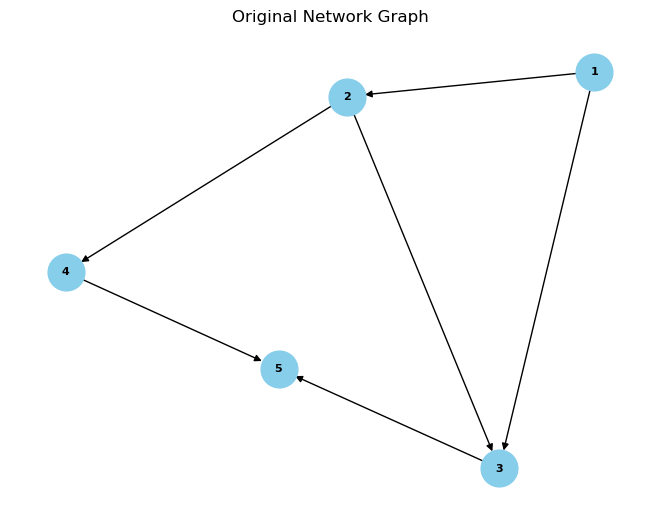

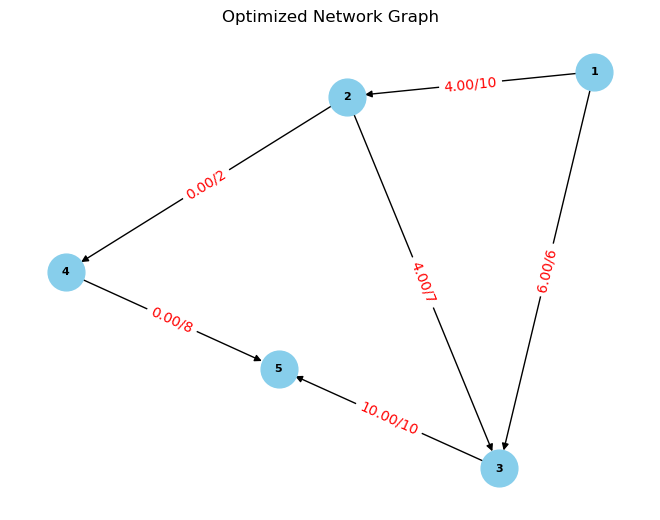

In [3]:

import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(N)

# Add edges to the graph
G.add_edges_from(A)

# Plot the original graph
pos = nx.spring_layout(G)  # You can choose a different layout if you prefer
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=8)
plt.title('Original Network Graph')
plt.show()

# Solve the optimization problem
result = solver.solve(model)

# Plot the optimized flow on the edges
optimized_flow = {(i, j): model.x[i, j].value for i, j in model.A}
edge_labels = {(i, j): f"{optimized_flow[i, j]:.2f}/{u[i, j]}" for i, j in model.A}

# Create a new directed graph with flow values as labels
G_optimized = nx.DiGraph()
G_optimized.add_nodes_from(N)
G_optimized.add_edges_from(A)

# Plot the optimized graph
plt.figure()
nx.draw(G_optimized, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_color='black', font_size=8)
nx.draw_networkx_edge_labels(G_optimized, pos, edge_labels=edge_labels, font_color='red')
plt.title('Optimized Network Graph')
plt.show()